Import libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro

ML libraries

In [43]:
# --- Model selection utilities ---
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# --- Preprocessing tools ---
from sklearn.preprocessing import StandardScaler

# --- Imputation techniques ---
from sklearn.experimental import enable_iterative_imputer #only this enables the iterative imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

# --- Classification models ---
from sklearn.linear_model import LogisticRegression


Import and inspect data

In [44]:
df = pd.read_csv('../data/diabetes.csv')
# Create an overview report
def data_overview(df):
    print(" Dataset Shape:")
    print(f"- Rows: {df.shape[0]}")
    print(f"- Columns: {df.shape[1]}\n")

    print(" Columns and Data Types:")
    print(df.dtypes)
    print("\n")

    print(" Missing Values:")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print(missing)
    else:
        print("- No missing values detected!")
    print("\n")

    print(" Basic Info:")
    df.info()

    print("\n Sample of Data:")
    display(df.head())

# Run the report
data_overview(df)

 Dataset Shape:
- Rows: 768
- Columns: 9

 Columns and Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


 Missing Values:
- No missing values detected!


 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-nul

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Descriptive Statitics

In [45]:
#Handling missing values that are annotated as 0
#First how to detect them
df.describe().T



,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [46]:
#We can see by the summary that the minimum value of some features is 0, which is pyhsiologically not possible.
#The features that are not possible to be 0 are:
#Glucose, BloodPressure, SkinThickness, Insulin, BMI
#For these we want to replace the 0 values with NaN
#Create a copy of the dataframe
df_nan = df.copy(deep= True) #deep copy to avoid changing the original dataframe
df_nan[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df_nan[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

print('Summary of missing values:')
df_nan.isnull().sum()

Summary of missing values:


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

We want to evaluate some imputers to determine which one would preprocess our dataset best. Use Logistic Regresssion (LR) as a probe model to evaluate how well each imputer prepares the data for classifcation tasks. For each imputer, we fit a pipeline (imputer + scaler + LR) and measure ROC AUC score using CV.
The ROC AUC reflects how well LR can separate the classes after imputation, helping us decide which imputer generates the most useful features. Higher ROC AUC indicates better preprocessing quality for later modeling. 

In [47]:
#X and y defined for testing.
X_eval = df_nan.drop(columns=['Outcome'])
y_eval = df_nan['Outcome']
imputers = {
    'SimpleMedian' : SimpleImputer(strategy='median'),
    'KNNImputer' : KNNImputer(),
    'Iteratiive_BayesRidge' : IterativeImputer(estimator=BayesianRidge(), random_state = 42),
    'Iterative_RandomForest' : IterativeImputer(estimator = RandomForestRegressor(n_estimators = 10, random_state= 42), random_state = 42)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, imputer in imputers.items():
    # Create a pipeline
    pipe = Pipeline([
        ('imputer', imputer),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    scores = cross_val_score(pipe, X_eval, y_eval, cv = cv, scoring = 'roc_auc')
    results[name] = scores
    print(f'{name}: {scores.mean():.3f} +/- {scores.std():.3f}')

    

SimpleMedian: 0.837 +/- 0.020
KNNImputer: 0.838 +/- 0.022
Iteratiive_BayesRidge: 0.837 +/- 0.022


/opt/anaconda3/envs/FoDS_11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/FoDS_11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/FoDS_11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/FoDS_11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Iterative_RandomForest: 0.836 +/- 0.021


/opt/anaconda3/envs/FoDS_11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [48]:
df_nan.to_csv('../data/nan_df.csv', index=False)    

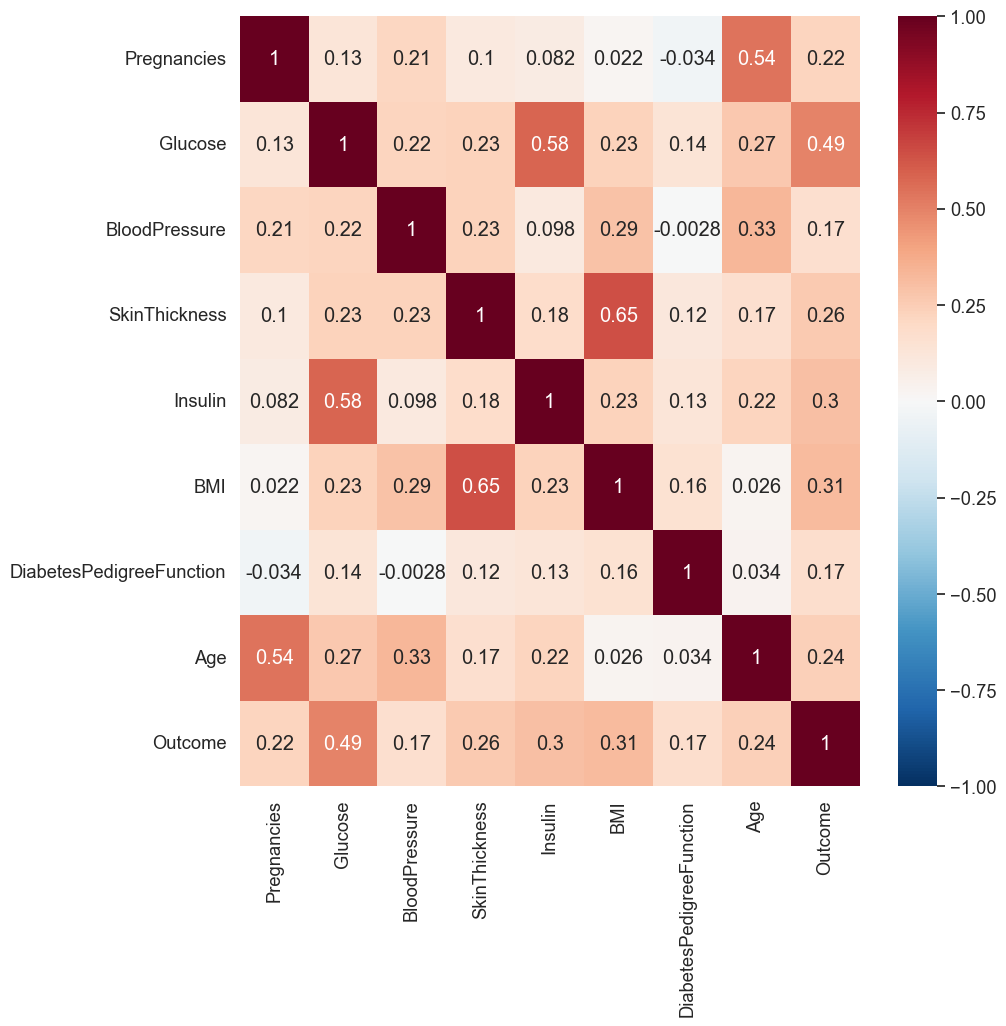

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_nan.corr(), vmin=-1.0, center=0, cmap='RdBu_r', annot=True)

plt.savefig('../archive/Figures/corr_nan.png', dpi = 300, bbox_inches='tight')
plt.show()

Distribution

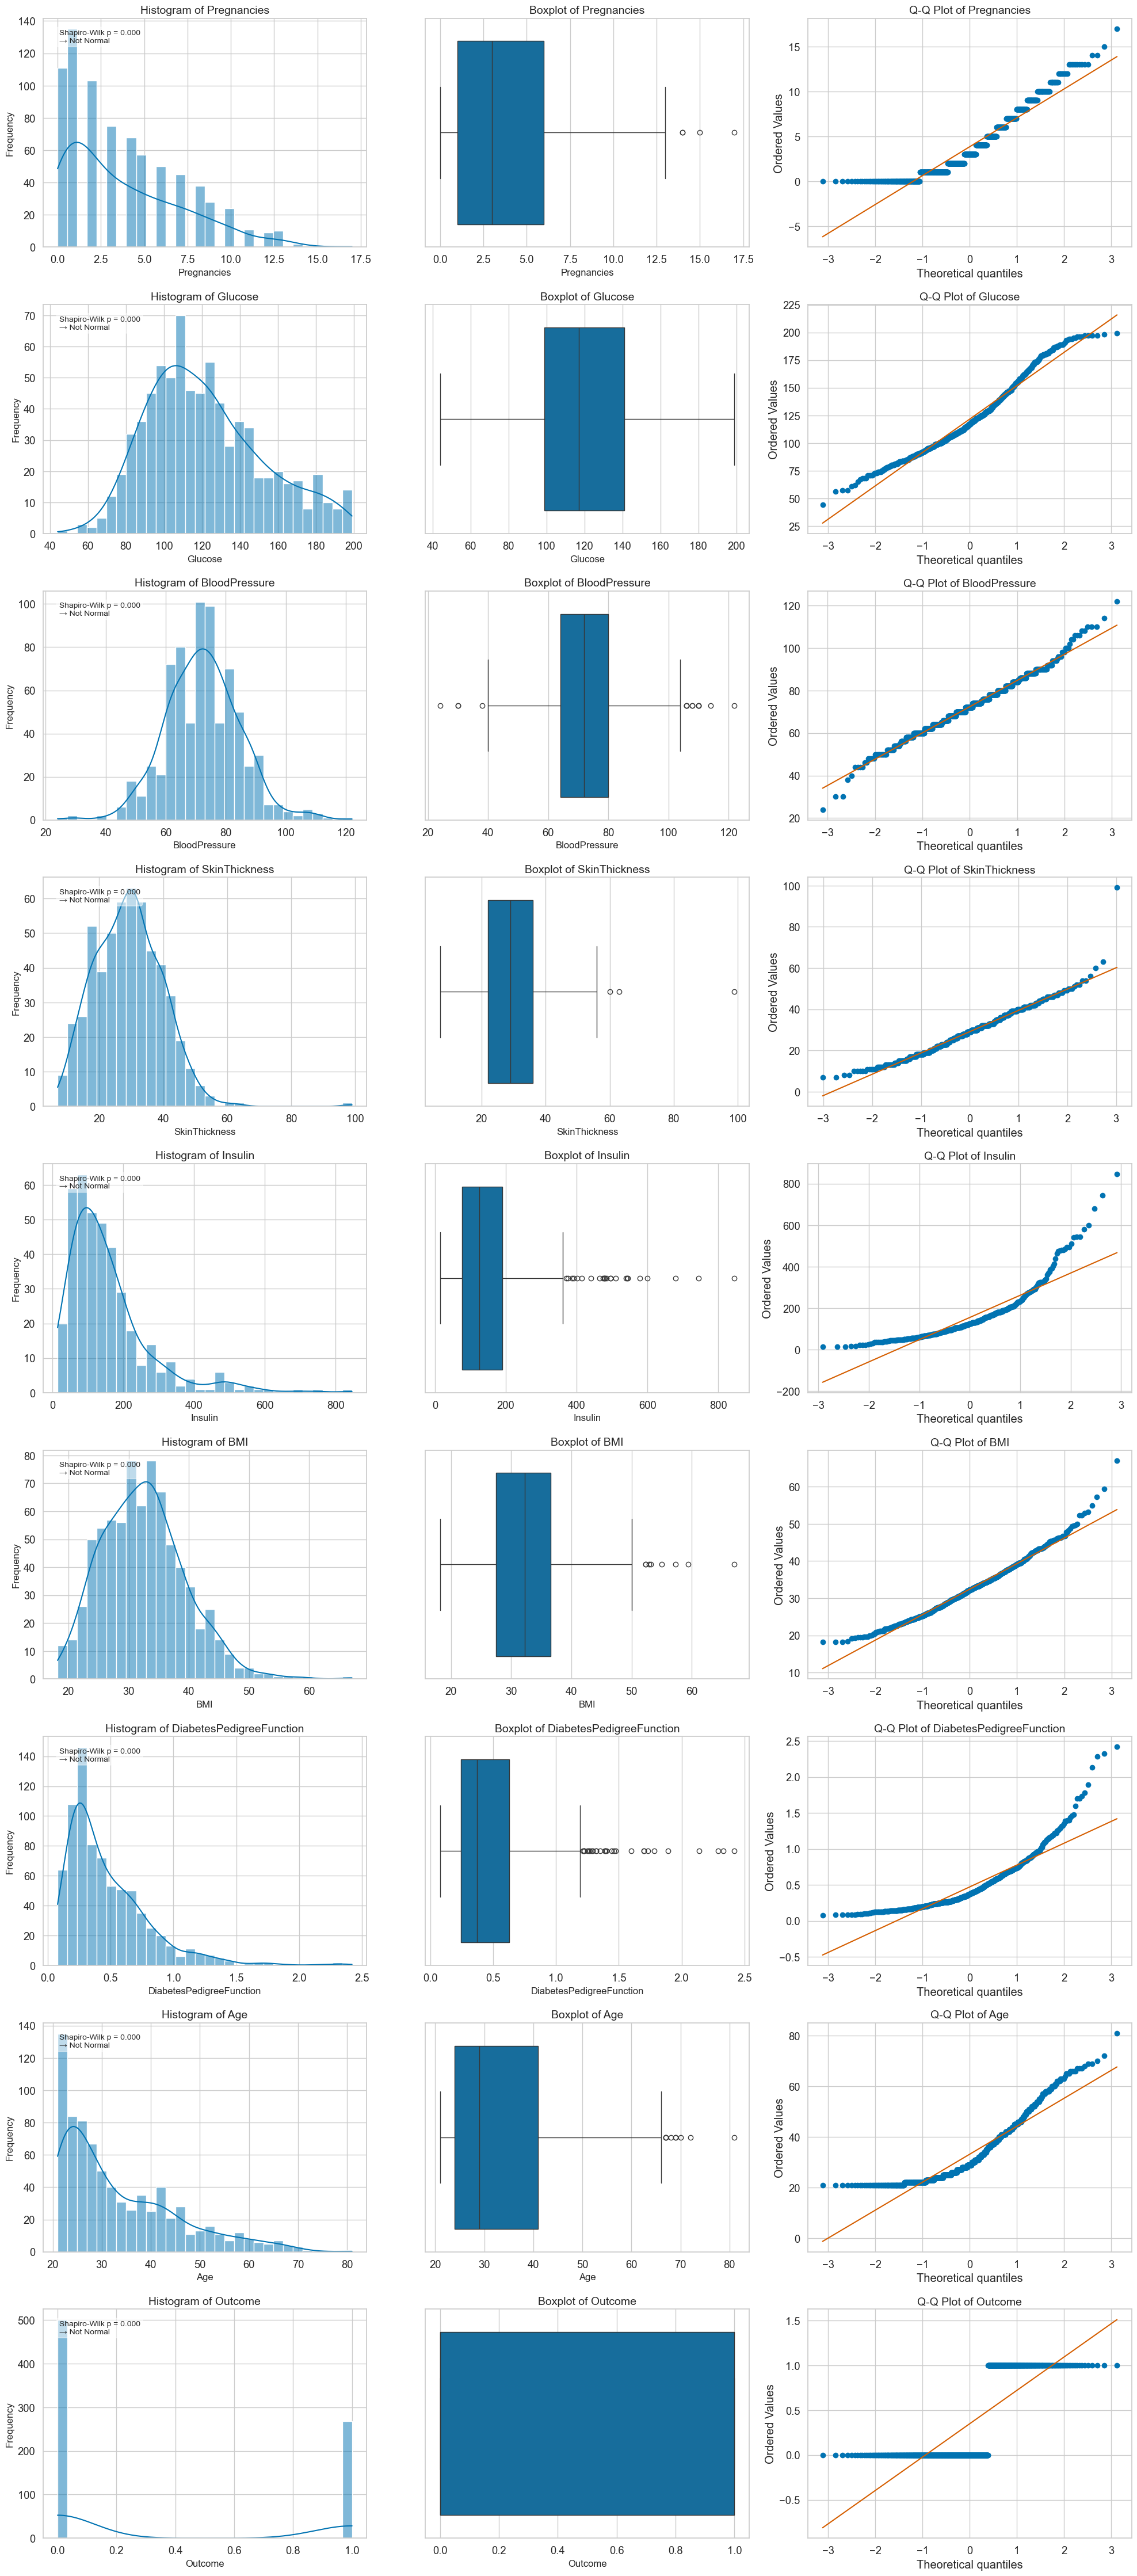

In [50]:
# Set seaborn style and colorblind palette
sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context('notebook', font_scale=1.2)

#Define num_cols

num_cols = df_nan.columns

# Create one big figure: (rows = number of columns, cols = 3 plots per feature)
fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(20, 5 * len(num_cols)))

# Loop through each numeric column and plot
for idx, col in enumerate(num_cols):

    # 1. Histogram with KDE
    sns.histplot(df_nan[col], kde=True, bins=30, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Histogram of {col}', fontsize=14)
    axes[idx, 0].set_xlabel(col, fontsize=12)
    axes[idx, 0].set_ylabel('Frequency', fontsize=12)

    # Shapiro-Wilk test
    stat, p_value = shapiro(df_nan[col].dropna())
    normality = "Normal" if p_value > 0.05 else "Not Normal"

    # Annotate p-value
    axes[idx, 0].text(0.05, 0.95, f'Shapiro-Wilk p = {p_value:.3f}\n→ {normality}',
                      transform=axes[idx, 0].transAxes,
                      fontsize=10,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # 2. Boxplot
    sns.boxplot(x=df_nan[col], ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Boxplot of {col}', fontsize=14)
    axes[idx, 1].set_xlabel(col, fontsize=12)

    # 3. Q-Q plot
    stats.probplot(df_nan[col].dropna(), dist="norm", plot=axes[idx, 2])
    axes[idx, 2].set_title(f'Q-Q Plot of {col}', fontsize=14)

# Make everything tight and clean
plt.tight_layout()

#Save the plot
plt.savefig('../archive/Figures/dist.png')

# Save the BIG figure
plt.show()

# (Optional) Dis

Detection of Outliers

In [51]:
# Create a dictionary to store outlier indices per column
outliers_iqr = {}

# Loop over each numeric column
for col in df_nan.select_dtypes(include=np.number).columns:
    Q1 = df_nan[col].quantile(0.25)
    Q3 = df_nan[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find the outliers 
    outlier_indices = df_nan[(df_nan[col] < lower_bound) | (df_nan[col] > upper_bound)].index.tolist()

    # Save
    outliers_iqr[col] = outlier_indices

# Print number of outliers per column
for feature, indices in outliers_iqr.items():
    print(f'{feature}: {len(indices)} outliers')

Pregnancies: 4 outliers
Glucose: 0 outliers
BloodPressure: 14 outliers
SkinThickness: 3 outliers
Insulin: 24 outliers
BMI: 8 outliers
DiabetesPedigreeFunction: 29 outliers
Age: 9 outliers
Outcome: 0 outliers


No handling of outliers.


Train und Test Split to look for class imbalance

In [52]:
#Split Features from Outcome and store separately
X = df_nan.drop('Outcome', axis=1)         # Features
y = df_nan['Outcome']                      # Outcome

#Check if X is stored properly
print("Feature Set:")
print(X.columns)


Feature Set:
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


In [53]:

#Teile die original Daten in Train und Test Datensets auf mit der GLEICHEN Verteilung wie das originale Datenset
#Und speichere die neuen Datensets als neue .csv Files
# Stratified 80/20 Split (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,   #Makes 20% of the Dataset the Test_set
    stratify=y,      #Makes a Split with the same Distribution as the Original Data
    random_state=42  #Takes same split even after Repetitions
)

# Neue DataFrames erstellen
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# # Speichern in neue CSV-Dateien
# train_df.to_csv('train_dataset.csv', index=False)
# test_df.to_csv('test_dataset.csv', index=False)


In [54]:
# Original distribution
print("Original class distribution:")
print(pd.Series(y).value_counts(normalize=True))

# Training set distribution
print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

# Test set distribution
print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Original class distribution:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

Training set class distribution:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64

Test set class distribution:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64
